[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Borgers-Examples-in-BMTK/blob/main/33-EI_Beta/33_EI_Beta.ipynb)

# Chapter 33- Beta rhythms from E-I Network
#### by Matthew Stroud and Gregory Glickert
This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

In this tutorial,we display an pyramidal - Interneuronal Network Gamma (PING) network entrain excitatory neurons (E-cells). Beta rhythms are 12-30 Hz, thus the firing of the E-cells must be within this range. We model 200 E-cells with an RTM model and the 50 PING cells with a WB model.

requirements:

 bmtk

 NEURON 7.4+

### Create nodes
The PING network, E-cells, and external input nodes are defined

In [1]:
import os
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython()) 
if RunningInCOLAB:  
  %pip install neuron==8.2.4 &> /dev/null
  %pip install bmtk &> /dev/null
  %pip install h5py==2.9.0 &> /dev/null

  root = 'Borgers-Examples-in-BMTK' # name of github repo
  folder = '33-EI_Beta'
  pathlist = normpath(os.getcwd()).split(sep)
  if pathlist[-1] != folder:
    rootidx = pathlist.index(root) if root in pathlist else -1
    if rootidx>0:
      os.chdir(join(sep,*pathlist[:rootidx]))
    !git clone https://github.com/Cyneuro/Borgers-Examples-in-BMTK
    os.chdir(join(root,folder))
    
print(os.system('nrnivmodl components/mechanisms')) # compile modfiles. Return 0 for success, 1 for failure.

/home/gjgpb9/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Translating gap.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/33-EI_Beta/x86_64/gap.c
Translating k_rtm.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/33-EI_Beta/x86_64/k_rtm.c
Thread Safe
Translating k_wb.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/33-EI_Beta/x86_64/k_wb.c
Thread Safe
Thread Safe
Translating leak.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/33-EI_Beta/x86_64/leak.c
Thread Safe
Translating na_rtm.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/33-EI_Beta/x86_64/na_rtm.c
Translating na_wb.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/33-EI_Beta/x86_64/na_wb.c
Thread Safe
Translating vecevent.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/33-EI_Beta/x86_64/vecevent.c
Thread Safe
Thread Safe


/home/gjgpb9/Borgers-Examples-in-BMTK/33-EI_Beta
Mod files: "components/mechanisms/components/mechanisms/gap.mod" "components/mechanisms/components/mechanisms/k_rtm.mod" "components/mechanisms/components/mechanisms/k_wb.mod" "components/mechanisms/components/mechanisms/leak.mod" "components/mechanisms/components/mechanisms/na_rtm.mod" "components/mechanisms/components/mechanisms/na_wb.mod" "components/mechanisms/components/mechanisms/vecevent.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../components/mechanisms/gap.mod
 -> NMODL ../components/mechanisms/k_rtm.mod
 -> NMODL ../components/mechanisms/k_wb.mod
 -> NMODL ../components/mechanisms/leak.mod
 -> NMODL ../components/mechanisms/na_rtm.mod
 -> NMODL ../components/mechanisms/na_wb.mod
 -> NMODL ../components/mechanisms/vecevent.mod
 -> Compiling gap.c
Notice: ARTIFICIAL_CELL is a synonym for POINT_PROCESS which hints that it
only affects and is affected by discrete events. As such it is not


In [2]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder

# E - Cells
n_E = 200

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

# ING network
n_I = 50

net.add_nodes(N=n_I, pop_name='PING',     # N = number of ING cells
        model_type='biophysical',
        model_template='hoc:WBInhCell', 
        morphology='blank.swc')

### Connection rules 

We add connections based on a probability defined below. To prevent autapses, if the node_id is equal between source and targe cell, no connection is made.

In [3]:
import random

def syn_connector(source,target,p):
    if source['node_id'] == target['node_id']:
        return 0
    return 1 if random.random() < p else 0

### Creating ING Edges

Probabilities and conductances that are commented are taken from chapter 33 of Borgers' book. Inhibitory connections between PING cells are added; Inhibitory connections from PING cells to E - cells are added; Excitatory connections between E-cells and PING cells are added.

In [4]:
g_ee = 0
g_ei = 0.1  #0.25
g_ie = 0.5  #0.5
g_ii = 0.5  #0.5

p_ee = 0.5  # 0.5
p_ei = 0.5  # 0.5
p_ie = 0.5  # 0.5
p_ii = 1   # 0.5



#E-E connections dont exist (g_ee = 0)
         
#E-I connections 
net.add_edges(source={'pop_name':'Exc'}, target={'pop_name':'PING'},
                    connection_rule=syn_connector, 
                    connection_params={'p':p_ei},
                    delay=0,
                    syn_weight = g_ei/n_E,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_ExcToInh.json',
                    model_template='Exp2Syn')

#I-I connections
net.add_edges(source={'pop_name':'PING'}, target={'pop_name':'PING'},
                    connection_rule=syn_connector, 
                    connection_params={'p':p_ii},
                    delay=0,
                    syn_weight = g_ii,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToInh.json',
                    model_template='Exp2Syn')
                    
#I-E connections
net.add_edges(source={'pop_name':'PING'}, target={'pop_name':'Exc'},
                    connection_rule=syn_connector,
                    connection_params={'p':p_ie},
                    delay=0,
                    syn_weight = g_ie,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToExc.json',
                    model_template='Exp2Syn')


In [5]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

### Need to add background nodes or give network a current clamp!

### Set up Simulation Environment

In [8]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=400.0, dt=0.1,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 #spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                #'input/ext_inp_poisson.h5')],
                 #file_current_clamp={              
                      #"input_type": "file_current_clamp",
                      #"module": "FileIClamp",
                      #"input_file":"input/amps.h5",
                      #"node_set":"all"
                # },
                 current_clamp={            # Creates a step current from 500.ms to 1500.0 ms
                    'amp': 0.400,
                    'delay': 0,
                    'duration': 30.0
                },
                 v_init= -65,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file = 'config.json',
                )

### Run the Simulation

In [9]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

numprocs=1


2025-01-24 11:45:39,236 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /home/gjgpb9/Borgers-Examples-in-BMTK/33-EI_Beta/components/mechanisms.
2025-01-24 11:45:39,291 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2025-01-24 11:45:39,492 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2025-01-24 11:45:42,871 [INFO] Running simulation for 400.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 400.000 ms with the time step 0.100 ms


2025-01-24 11:45:42,873 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2025-01-24 11:45:42,873 [INFO] Block save every 4000 steps


INFO:NEURONIOUtils:Block save every 4000 steps


2025-01-24 11:45:58,316 [INFO]     step:4000 t_sim:400.00 ms


INFO:NEURONIOUtils:    step:4000 t_sim:400.00 ms


2025-01-24 11:45:58,342 [INFO] Simulation completed in 15.47 seconds 


INFO:NEURONIOUtils:Simulation completed in 15.47 seconds 


### Analyze Results

We did not add initial voltage values to the PING network nor the E - cells. Because of a synchronous initialization, only the ING cell entrainment of the E-cells can be observed. The E - cells are already synchronous.

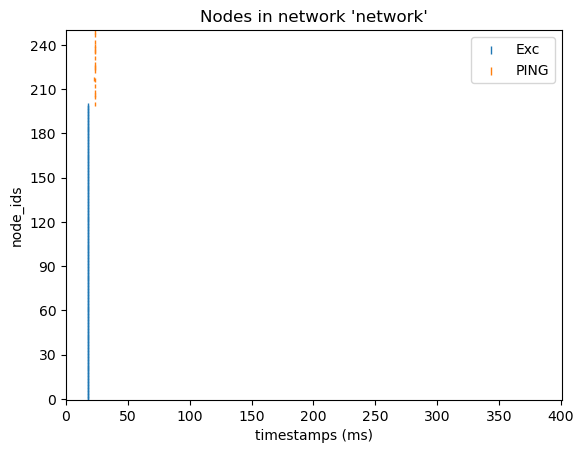

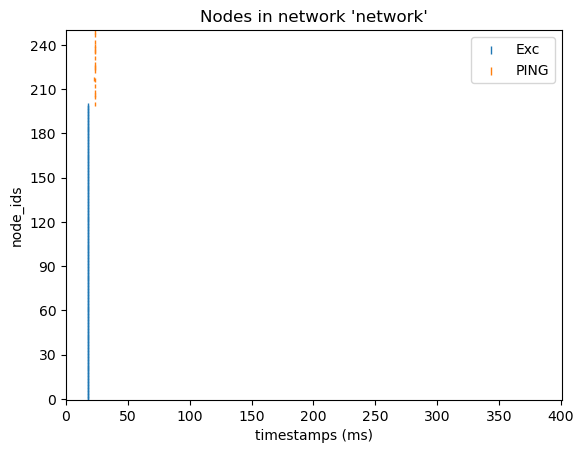

In [10]:
from bmtk.analyzer.spike_trains import plot_raster,plot_rates_boxplot

plot_raster(config_file='config.json', with_histogram=False, population='network', group_by='pop_name')

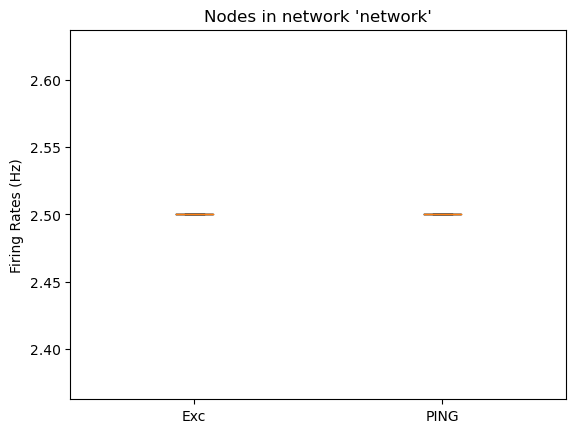

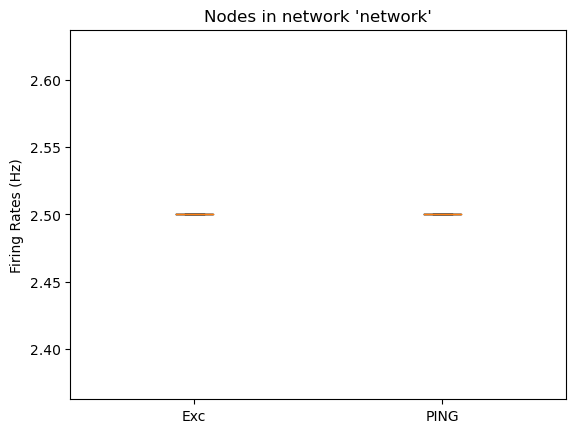

In [11]:
plot_rates_boxplot(config_file='config.json', group_by='pop_name')

The PING network successfully entrained the E-cells (Exc) at ~20 Hz which is in Beta wave range